In [1]:
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import requests
import pandas as pd
import seaborn as sns

In [2]:
%load_ext blackcellmagic

In [3]:
page = requests.get("https://onyxcoffeelab.com/products/2023-advent-calendar")
soup = BeautifulSoup(page.text)

In [4]:
recipes = []
for coffee in soup.find_all("div", {"class": "pop-left"}):
    data = {
        "Name": coffee.h2.string,
    }

    for span in coffee.find("div", {"class": "features"}).find_all("span"):
        feature, value = span.string.split(": ")
        if feature != "Origin":
            data[feature] = value

    setup_ps = coffee.find("div", {"class": "box-setup"}).find_all("p")
    data["Filter"] = setup_ps[0].string[11:]
    temperature_in_F = float(setup_ps[2].string.split()[-1][:-2])
    data["temperature"] = (temperature_in_F - 32) / 1.8

    for line in coffee.find("div", {"class": "box-grind"}).p.text.split("\n"):
        grind, grinder = line.split(" ", maxsplit=1)
        if grinder == "um":
            grinder = "Microns"
        elif grinder == "EK43":
            grinder = "Mahlkonig EK43"
        elif grinder == "Baratza Vario/Forte":
            grinder = "Baratza Vario+"
        elif grinder == "2/3 Fellow Ode Gen 2":
            grinder = "Fellow Ode Gen 2"
        data[grinder] = grind
    data["Drain"] = (
        coffee.find("div", {"class": "box-brew"})
        .p.text.split("\n")[-1]
        .split()[0]
        .replace("~", "")
    )
    recipes.append(data)

recipes = pd.DataFrame(recipes)
recipes.index = recipes.index + 1
recipes["Elevation"] = recipes["Elevation"].str[:-5]
int_grinders = [
    "Microns",
    "Baratza Encore",
    "Comandante C40",
]
recipes[int_grinders] = recipes[int_grinders].astype(int)
float_grinders = [
    "Mahlkonig EK43",
    "Fellow Ode Gen 2",
]
recipes[float_grinders] = recipes[float_grinders].astype(float)
recipes["Drain"] = pd.to_timedelta("00:" + recipes["Drain"])
recipes.to_csv("data/onyx_coffee_advent_calendar_2023.csv")
recipes

,Name,Variety,Elevation,Region,Process,Filter,temperature,Microns,Mahlkonig EK43,Baratza Encore,Baratza Vario+,Comandante C40,Fellow Ode Gen 2,Drain
1,Framily,Heirloom,2000,Yirgacheffe,Washed,v60 Cone Filter,95.555556,570,8.2,13,5v,19,3.66,0 days 00:03:40
2,Ethiopia Hambela Bishan Fugu,Heirloom,2000,Guji,Washed,Kalita 185 Filter,95.000000,756,11.0,21,8q,25,5.00,0 days 00:03:11
3,Kenya Gichathaini AA,SL28 SL34 & Batian,1800,Nyeri,Washed,Cone filter,95.000000,682,10.0,18,7o,23,4.00,0 days 00:03:30
4,Colombia Aponte Village,Caturra Bourbon & Castillo,2100,Narino,Honey,v60 Cone Filter,96.111111,653,9.5,17,7e,22,4.30,0 days 00:02:50
5,Mexico Puebla Zapotitlan #2,Bourbon & Typica,1650,Puebla,Washed,Kalita 185 Flat Filter,96.111111,515,7.5,11,5e,17,3.30,0 days 00:03:10
6,Costa Rica Las Lajas Black Honey,Catuai,1600,Alajuela,Honey,Kalita 185 Flat Filter,96.111111,490,7.1,10,4s,16,3.00,0 days 00:02:45
7,Burundi Long Miles Gaharo Hill,Red Bourbon,1950,Kayanza,Washed,v60 Cone Filter,94.444444,528,7.5,12,5i,18,3.30,0 days 00:04:00
8,Guatemala Finca Travesia Natural,Bourbon Catuai & Caturra,NaN,Antigua,Natural,Kalita 185 Filter,94.444444,490,7.1,10,4s,16,3.00,0 days 00:02:50
9,El Salvador Santa Rosa Honey,Pacamara,1800,Chalatenango,Honey,Kalita Flat Filter,95.555556,610,8.8,15,6m,20,4.00,0 days 00:02:55
10,Kenya Muthingini AA,SL28 SL34 & Batian,1800,Kirinyaga,Washed,Kalita 185 Flat Filter,96.111111,721,10.5,20,8f,24,5.00,0 days 00:03:00


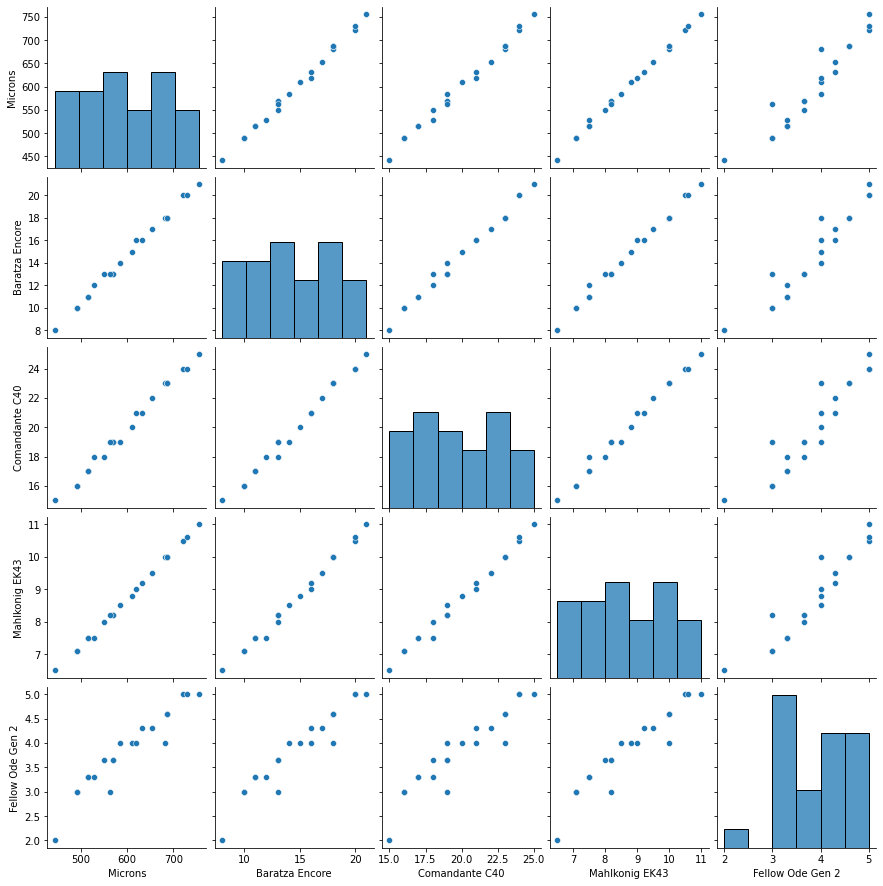

In [5]:
grinds = int_grinders + float_grinders

sns.pairplot(recipes[grinds])
plt.show()

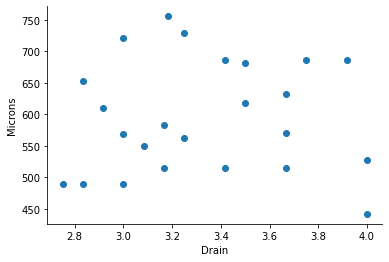

In [6]:
plt.scatter(recipes["Drain"] / pd.to_timedelta("60s"), recipes["Microns"])
plt.gca().set_xlabel("Drain")
plt.gca().set_ylabel("Microns")
sns.despine()
plt.show()

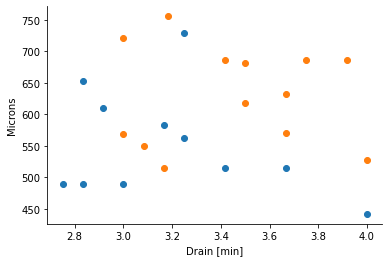

In [7]:
for _, group in recipes.groupby(recipes["Process"] == "Washed"):
    plt.scatter(group["Drain"] / pd.to_timedelta("1m"), group["Microns"])
plt.gca().set_xlabel("Drain [min]")
plt.gca().set_ylabel("Microns")
sns.despine()
plt.show()

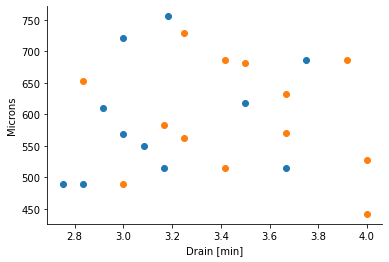

In [8]:
for _, group in recipes.groupby(recipes["Filter"].str.contains("one")):
    plt.scatter(group["Drain"] / pd.to_timedelta("1m"), group["Microns"])
plt.gca().set_xlabel("Drain [min]")
plt.gca().set_ylabel("Microns")
sns.despine()
plt.show()